# BOOK RECOMMENDER PROJECT

In [137]:
##  https://www.kaggle.com/datasets/rxsraghavagrawal/book-recommender-system?resource=download&select=BX-Users.csv

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.stats.api as sms
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.float_format', lambda x: '%.5f' % x)
import warnings
warnings.filterwarnings("ignore")

import requests
from PIL import Image
import io
import random
from io import BytesIO

Book_Ratings=pd.read_csv('data/BX-Book-Ratings.csv',sep=";",encoding='latin-1')
Users=pd.read_csv('data/BX-Users.csv',sep=";",encoding='latin-1')
Books=pd.read_csv('data/BX-Books.csv',sep=";",encoding='latin-1',error_bad_lines=False)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


## Data Manipulation

In [2]:
## 3 datanin birlestirilmesi: MERGE
df= Book_Ratings.merge(Users, how= "outer", on= "User-ID")
df2= df.merge(Books, how= "outer", on= "ISBN")

# Book ratinglerden 0 olan satirlarin silinmesi
df3 = df2[~(df2["Book-Rating"]== 0)]

# Eksik verilerin incelenmesi
## year column
df3["Year-Of-Publication"] = df3["Year-Of-Publication"].fillna(0)
df3["Year-Of-Publication"] = df3["Year-Of-Publication"].map(lambda x: str(x).strip(" ' "))   # ise yaradi
df3 = df3[ (df3["Year-Of-Publication"] < "2021") & (df3["Year-Of-Publication"] > "1910") ]  

# country Column
df3["country"]=df3['Location'].str.split(',').str[-1]
df3["country"] = df3['country'].str.replace('[^\w\s]','')
df3['country'] = df3["country"].str.replace('\d+', '')

# Dolu kolonlarin alinmasi
df4 = df3[~(df3["ISBN"].isnull())]

df5 = df4[~(df4["Book-Title"].isnull())]   


In [3]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379204 entries, 1 to 1324563
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              378016 non-null  float64
 1   ISBN                 379204 non-null  object 
 2   Book-Rating          378016 non-null  float64
 3   Location             378016 non-null  object 
 4   Age                  265453 non-null  float64
 5   Book-Title           379204 non-null  object 
 6   Book-Author          379203 non-null  object 
 7   Year-Of-Publication  379204 non-null  object 
 8   Publisher            379202 non-null  object 
 9   Image-URL-S          379204 non-null  object 
 10  Image-URL-M          379204 non-null  object 
 11  Image-URL-L          379204 non-null  object 
 12  country              378016 non-null  object 
dtypes: float64(3), object(10)
memory usage: 40.5+ MB


In [4]:
# df5.to_csv('df5.csv', index=False)

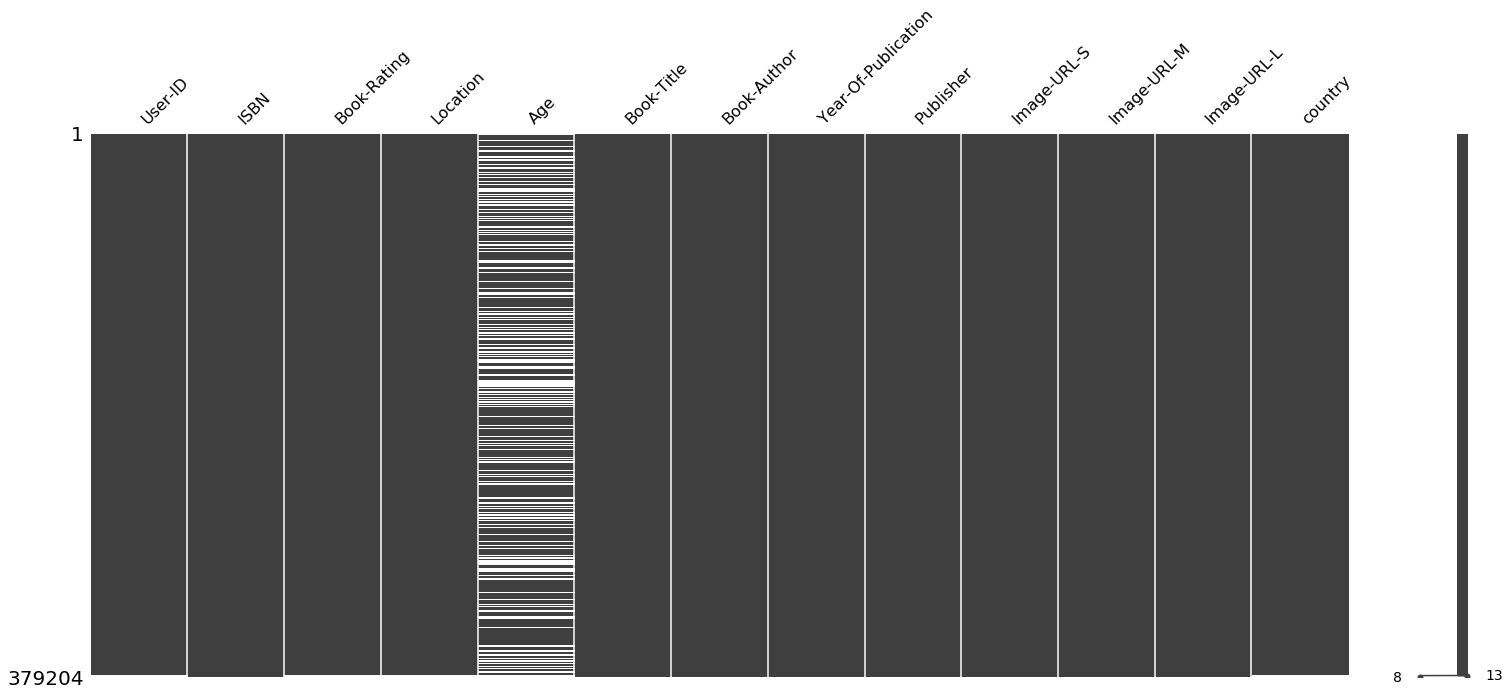

In [5]:
import missingno as msno
msno.matrix(df5);

### Age Analysis

In [12]:
df_statistics = df5.dropna()
df_statistics = df_statistics[(df_statistics["Age"]< 70) & (df_statistics["Age"]> 18)].reset_index(drop=True)

In [13]:
df_statistics["Age"].describe()

count    248437.000000
mean         37.456136
std          11.069694
min          19.000000
25%          29.000000
50%          35.000000
75%          46.000000
max          69.000000
Name: Age, dtype: float64

### Rating Analysis

In [14]:
df_Rating = df_statistics.groupby('Book-Title')['Book-Rating'].agg(
            Rating_mean='mean',
            Rating_count='count',
).sort_values(by="Rating_count" , ascending=False) 

In [15]:
df_Rating.head(100)

,Rating_mean,Rating_count
Book-Title,,
The Lovely Bones: A Novel,8.242081,442
Wild Animus,4.319149,423
The Da Vinci Code,8.438356,365
The Secret Life of Bees,8.466418,268
Bridget Jones's Diary,7.782609,253
Angels &amp; Demons,8.045082,244
The Nanny Diaries: A Novel,7.500000,238
Life of Pi,8.097458,236
The Red Tent (Bestselling Backlist),8.289593,221


In [24]:
df_Rating.sort_values(by="Rating_mean" , ascending=False)

,Rating_mean,Rating_count
Book-Title,,
"The Two Towers (The Lord of the Rings, Part 2)",9.373737,99
Harry Potter and the Goblet of Fire (Book 4),9.210191,157
Harry Potter and the Sorcerer's Stone (Book 1),9.159664,119
To Kill a Mockingbird,9.108434,166
"The Fellowship of the Ring (The Lord of the Rings, Part 1)",9.097015,134
Harry Potter and the Prisoner of Azkaban (Book 3),9.093407,182
Harry Potter and the Order of the Phoenix (Book 5),9.062112,161
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),9.025773,194
1984,8.866071,112


In [16]:
df_Rating["Rating_count"].describe([.25, .5, .75, .90, .95, .97])

count    102288.000000
mean          2.428799
std           6.662125
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
90%           4.000000
95%           7.000000
97%          10.000000
max         442.000000
Name: Rating_count, dtype: float64

### Age Mean By Most Popular 10 Books

In [17]:
def popular_books(df,n=100):
    rating_count=df.groupby("Book-Title").count()["Book-Rating"].reset_index()
    rating_count.rename(columns={"Book-Rating":"NumberOfVotes"},inplace=True)
    
    rating_average=df.groupby("Book-Title")["Book-Rating"].mean().reset_index()
    rating_average.rename(columns={"Book-Rating":"AverageRatings"},inplace=True)
    age_average=df_statistics.groupby("Book-Title")["Age"].mean().reset_index()
    age_average.rename(columns={"Age":"Age_mean"},inplace=True)

    popularBooks=rating_count.merge(rating_average,on="Book-Title")
    popularBooks=popularBooks.merge(age_average,on="Book-Title")
    
    
    def weighted_rate(x):
        v=x["NumberOfVotes"]
        R=x["AverageRatings"]
        
        return ((v*R) + (m*C)) / (v+m)
    
    C=popularBooks["AverageRatings"].mean()
    m=popularBooks["NumberOfVotes"].quantile(0.90)
    
    popularBooks=popularBooks[popularBooks["NumberOfVotes"] >=100]
    popularBooks["Popularity"]=popularBooks.apply(weighted_rate,axis=1)
    popularBooks=popularBooks.sort_values(by="Popularity",ascending=False)
    return popularBooks[["Book-Title","NumberOfVotes","AverageRatings","Popularity", "Age_mean"]].reset_index(drop=True).head(n)



In [18]:
df_book_age = popular_books(df_statistics).head(10)
df_book_age

,Book-Title,NumberOfVotes,AverageRatings,Popularity,Age_mean
0,Harry Potter and the Goblet of Fire (Book 4),157,9.210191,9.171579,32.191083
1,Harry Potter and the Sorcerer's Stone (Book 1),119,9.159664,9.110766,33.789916
2,To Kill a Mockingbird,166,9.108434,9.074260,33.734940
3,Harry Potter and the Prisoner of Azkaban (Book 3),182,9.093407,9.062496,33.439560
4,The Fellowship of the Ring (The Lord of the Ri...,134,9.097015,9.055248,32.097015
5,Harry Potter and the Order of the Phoenix (Boo...,161,9.062112,9.028026,33.254658
6,Harry Potter and the Sorcerer's Stone (Harry P...,194,9.025773,8.998102,33.515464
7,1984,105,8.923810,8.877287,29.695238
8,Harry Potter and the Chamber of Secrets (Book 2),210,8.857143,8.834693,33.990476
9,Fahrenheit 451,120,8.725000,8.690518,33.025000


Text(0.5, 1.0, 'Age Mean By Most Popular 10 Books')

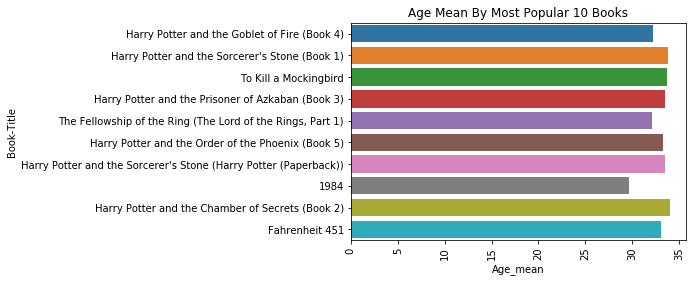

In [19]:
ax = sns.barplot(y=df_book_age["Book-Title"], x= df_book_age["Age_mean"])
ax.tick_params(axis='x', labelrotation = 90)
ax.set_title("Age Mean By Most Popular 10 Books")

### Age & Country TEST

In [20]:
df_country = df_statistics.groupby('country')['Age'].agg(
            Age_mean='mean',
            Age_count='count'
).sort_values(by="Age_count" , ascending=False).head(20)

df_country

,Age_mean,Age_count
country,,
usa,38.507473,172563
canada,36.806767,23495
united kingdom,37.314729,10177
germany,32.333673,7846
spain,33.544633,6419
australia,34.902305,4381
,39.629552,4311
france,31.084038,3784
portugal,30.067057,3072


In [21]:
# İki ulkenin yas bilgisi betimsel İstatistiklerinin Karşılaştırılması
desc_compare_df = pd.DataFrame ({"usa_age": df_statistics.loc[df_statistics["country"]== " usa", "Age"].describe (),
                                 "canada_age": df_statistics.loc[df_statistics["country"]== " canada", "Age"].describe ()})


In [22]:
desc_compare_df  # örnekleme(count) 30 dan fazla olmali

,usa_age,canada_age
count,172563.000000,23495.000000
mean,38.507473,36.806767
std,11.090721,10.473645
min,19.000000,19.000000
25%,30.000000,29.000000
50%,37.000000,35.000000
75%,47.000000,45.000000
max,69.000000,69.000000


In [23]:
# Güven Aralığı Değerlendirmesi

In [24]:
sms.DescrStatsW (df_statistics.loc[df_statistics["country"]== " usa", "Age"]).tconfint_mean ()
# %95 guven araliginda 

(38.45514427776651, 38.559800988599974)

In [25]:
sms.DescrStatsW (df_statistics.loc[df_statistics["country"]== " canada", "Age"]).tconfint_mean ()
# %95 guven araliginda 

(36.67283656379351, 36.94069823084365)

In [26]:
# yorum: % 95 araligindaki ortalama degerler cakismadigi icin aslinda buradan farkliligi anliyoruz.

In [27]:
# NORMALLIK VARSAYIMI KONTROLÜ (SHAPIRO)

In [28]:
# tek shapiroya bakmak yeterli, biri bile normal degilse direk non parametrik

In [29]:
test_stat, pvalue = shapiro(df_statistics.loc[df_statistics["country"]== " usa", "Age"])
print("Test Stat = %.4f p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.9712 p-value = 0.0000


In [30]:
# p < 0.05 oldugundan H0 red edilir. Varsayim saglanmaz, NORMAL DEGIL,
# o yuzden non parametrik bir test kullanmamiz lazim.

In [31]:
test_stat, pvalue = shapiro(df_statistics.loc[df_statistics["country"]== " canada", "Age"])
print("Test Stat = %.4f p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.9620 p-value = 0.0000


In [32]:
# p < 0.05 oldugundan H0 red edilir. Varsayim saglanmaz, NORMAL DEGIL,
# o yuzden non parametrik bir test kullanmamiz lazim.

In [33]:
## mannwhitneyu NONPARAMETRIK TEST

In [34]:
test_stat, pvalue = mannwhitneyu(df_statistics.loc[df_statistics["country"]== " usa", "Age"],
                          df_statistics.loc[df_statistics["country"]== " canada", "Age"])
print("Test Stat = %.4f p-value = %.4f" % (test_stat, pvalue))

Test Stat = 2203731164.5000 p-value = 0.0000


In [35]:
# ??????????????????????????
# Yorum: p < 0.05 oldugundan H0 red edilir. Yani anlamli bir farklilik vardir.!
# usa daki yas ortalamasiyla canada daki yas ortalamasi arasinda önemli ölcude fark vardir.


### Age Mean by Country

In [36]:
df_country_2 = df_country.reset_index()
df_country_2 = df_country_2[["country", "Age_mean"]]

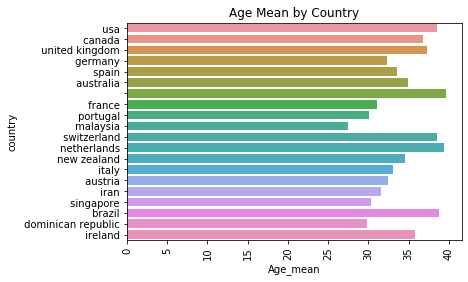

In [37]:
sns.barplot(y=df_country_2["country"], x= df_country_2["Age_mean"]).set_title("Age Mean by Country")
plt.tick_params(axis='x', labelrotation = 90)


In [111]:
df_country_3 = df_statistics.groupby('country')['Age']  #.agg(
          #  Age_count='count'
#).sort_values(by="Age_count" , ascending=False).head(20)

df_country_3

In [110]:
plt.figure(figsize=(14, 5))
sns.boxplot(data=df_statistics, x="Age_count", y="country");
#plt.show()

ValueError: Could not interpret input 'Age_count'

<Figure size 1008x360 with 0 Axes>

### Number of Books Per Year

In [101]:
# Books.groupby("Year-Of-Publication").agg({"Year-Of-Publication" : "count"})

df_year_book = df5.groupby("Year-Of-Publication").agg({"Book-Title" : "count"})
df_year_book

,Book-Title
Year-Of-Publication,
1911,8
1920,39
1923,16
1924,1
1925,3
1926,3
1927,7
1928,2
1929,12


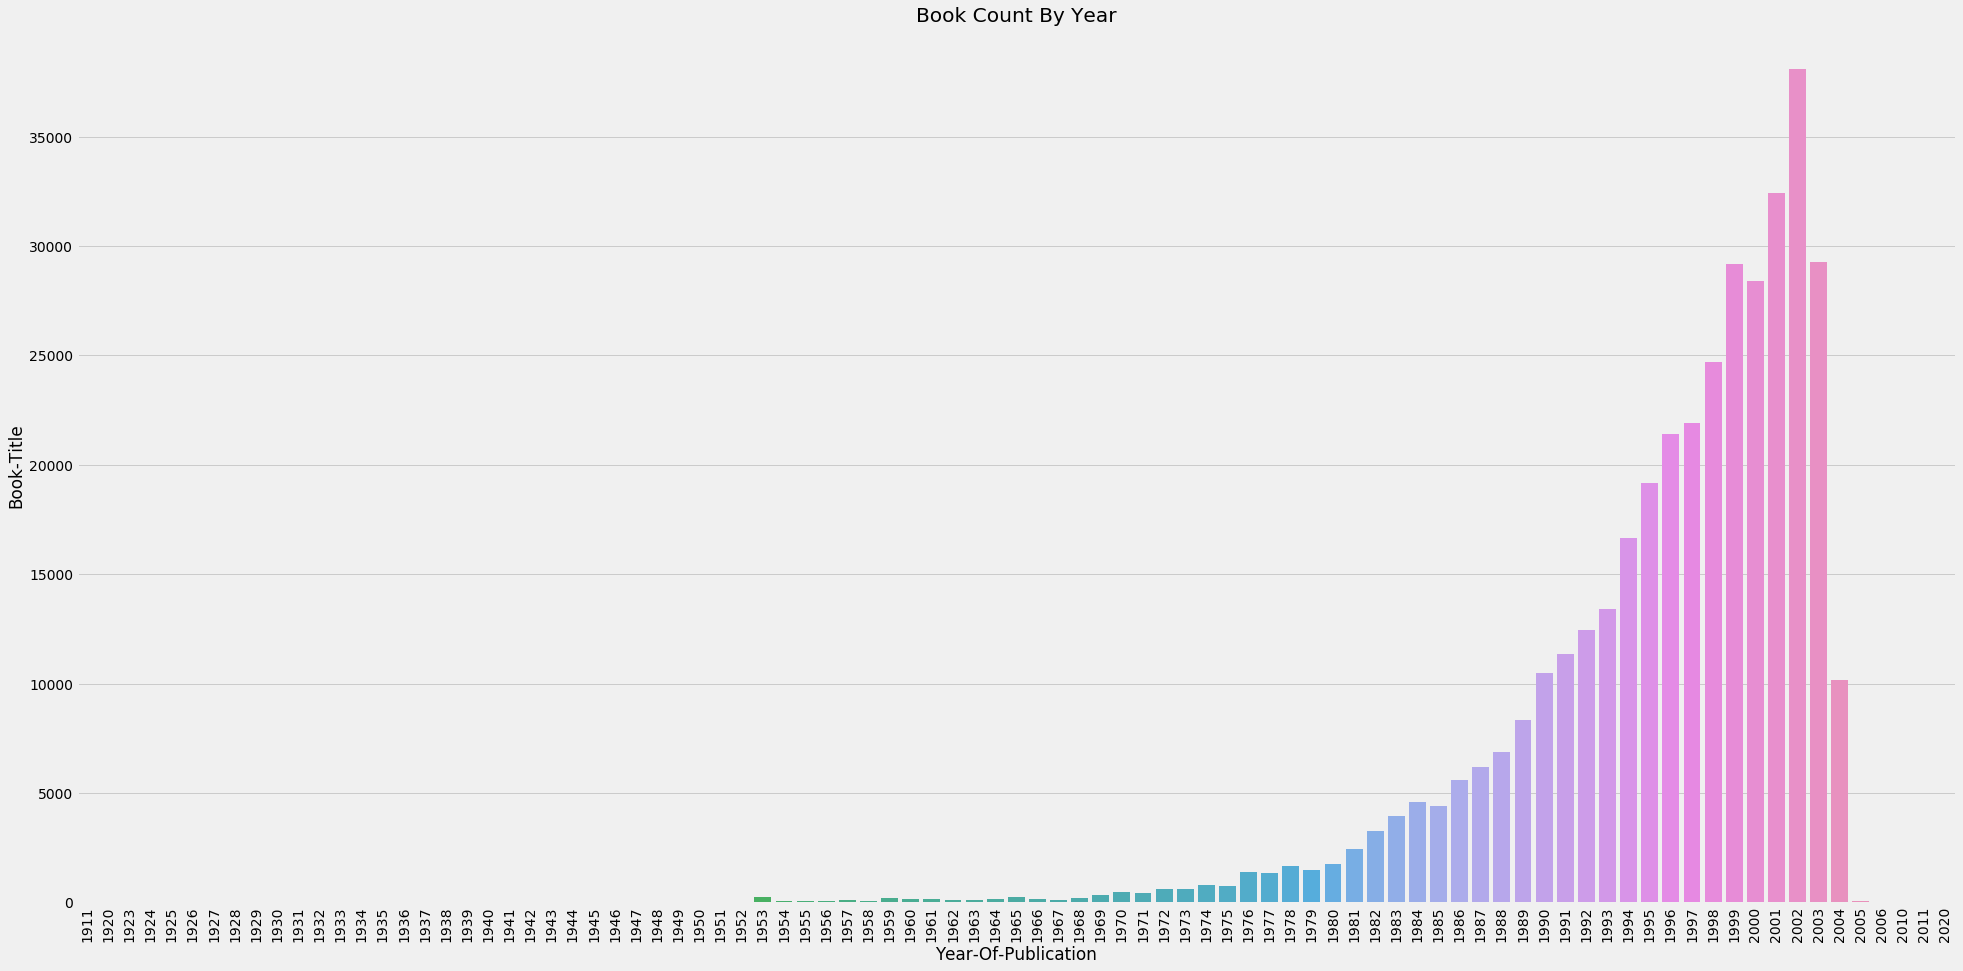

In [102]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 15))
sns.barplot( y= df_year_book["Book-Title"] , x= df_year_book.index ).set_title("Book Count By Year")
plt.tick_params(axis='x', labelrotation = 90)

### Number of Books By The Author

In [82]:
df_author_book = df5.groupby("Book-Author").agg({"Book-Title" : "nunique"})
df_author_book.sort_values(by= "Book-Title" , ascending= False).head(20)

,Book-Title
Book-Author,
William Shakespeare,345
Agatha Christie,308
Stephen King,282
Barbara Cartland,279
Nora Roberts,210
Carolyn Keene,186
Ann M. Martin,180
Terry Pratchett,175
Isaac Asimov,173


In [ ]:
## ??? yazarlarin aldigi ratinglerin siralamasi, 30 gozlem uzerindeki yazarlarin ilk 10 u kim 

In [103]:
df_author_rating = df5.groupby("Book-Author").agg({"Book-Rating" : "mean"})
df_author_rating.sort_values(by= "Book-Rating" , ascending= False).head(20)

,Book-Rating
Book-Author,
D. Chiel,10.0
Larry W. Dennis,10.0
Lasker's Manual of Chess,10.0
Lary May,10.0
Lars Svensson,10.0
Lars Pearson,10.0
Carole Tonkinson,10.0
"Larry, Jr. Crabb",10.0
Carolee Bateson-Koch,10.0


In [112]:
df_author_rating = df5.groupby('Book-Author')['Book-Rating'].agg(
            Book_Rating_mean='mean',
            Book_Rating_count='count'
).sort_values(by="Book_Rating_count" , ascending=False).head(10)

df_author_rating

,Book_Rating_mean,Book_Rating_count
Book-Author,,
Stephen King,7.819644,4602
Nora Roberts,7.629680,2938
John Grisham,7.523941,2527
James Patterson,7.697402,2386
J. K. Rowling,8.970218,1746
Mary Higgins Clark,7.503589,1672
Janet Evanovich,7.944929,1489
Dean R. Koontz,7.572203,1475
Anne Rice,7.387952,1245


## Popularity Based (most popular books)

In [38]:
def popular_books(df):
    rating_count=df.groupby("Book-Title").count()["Book-Rating"].reset_index()
    rating_count.rename(columns={"Book-Rating":"NumberOfVotes"},inplace=True)
    
    rating_average=df.groupby("Book-Title")["Book-Rating"].mean().reset_index()
    rating_average.rename(columns={"Book-Rating":"AverageRatings"},inplace=True)
    
    popularBooks=rating_count.merge(rating_average,on="Book-Title")
    
    def weighted_rate(x):
        v=x["NumberOfVotes"]
        R=x["AverageRatings"]
        
        return ((v*R) + (m*C)) / (v+m)
    
    C=popularBooks["AverageRatings"].mean()
    m=popularBooks["NumberOfVotes"].quantile(0.90)
    
    popularBooks=popularBooks[popularBooks["NumberOfVotes"] >=90]
    popularBooks["Popularity"]=popularBooks.apply(weighted_rate,axis=1)
    popularBooks=popularBooks.sort_values(by="Popularity",ascending=False)
    popularBooks= popularBooks.head(10)
    
    # print ("MOST POPULAR 10 BOOKS", popularBooks.reset_index(drop=True))
    
    fig,ax=plt.subplots(1,10, figsize=(17,5))
    fig.suptitle("MOST POPULAR 10 BOOKS",fontsize=40,color="deepskyblue")
    for i in range(len(popularBooks["Book-Title"].tolist())):
        url=df.loc[df["Book-Title"]==popularBooks["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
    
        headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36' }
        response = requests.get(url, stream=True, headers = headers)
        img = Image.open(io.BytesIO(response.content))
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title("RATING: {} ".format(round(df[df["Book-Title"]==popularBooks["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=10)
        fig.show()
    
    

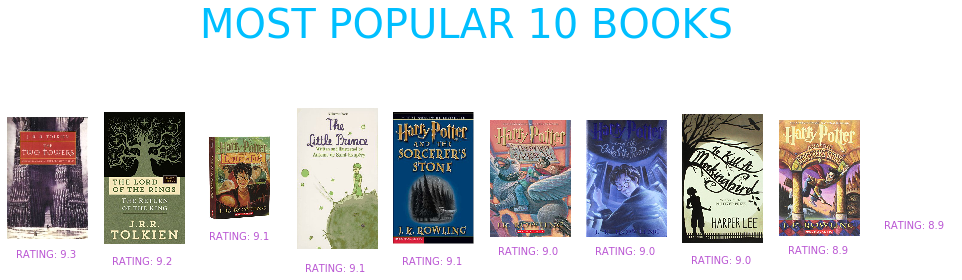

In [39]:
popular_books(df5)

## Item Based

In [40]:
def item_based(bookTitle):
    bookTitle=str(bookTitle)
    
    if bookTitle in df5["Book-Title"].values:
        rating_count=pd.DataFrame(df5["Book-Title"].value_counts())
        rare_books=rating_count[rating_count["Book-Title"]<=50].index
        common_books=df5[~df5["Book-Title"].isin(rare_books)]
        
        if bookTitle in rare_books:
            most_common=pd.Series(common_books["Book-Title"].unique()).sample(3).values
            print("No Recommendations for this Book ☹️ \n ")
            print("YOU MAY TRY: \n ")
            print("{}".format(most_common[0]), "\n")
            print("{}".format(most_common[1]), "\n")
            print("{}".format(most_common[2]), "\n")
        else:
            common_books_pivot = common_books.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
            title = common_books_pivot[bookTitle]
            recommendation_df = pd.DataFrame(common_books_pivot.corrwith(title).sort_values(ascending=False)).reset_index(drop=False)

            if bookTitle in [title for title in recommendation_df["Book-Title"]]:
                recommendation_df=recommendation_df.drop(recommendation_df[recommendation_df["Book-Title"]==bookTitle].index[0])
                
            less_rating=[]
            for i in recommendation_df["Book-Title"]:
                if df5[df5["Book-Title"]==i]["Book-Rating"].mean() < 5:
                    less_rating.append(i)
            if recommendation_df.shape[0] - len(less_rating) > 5:
                recommendation_df=recommendation_df[~recommendation_df["Book-Title"].isin(less_rating)]
                
            recommendation_df=recommendation_df[0:5]
            recommendation_df.columns=["Book-Title","Correlation"]
            
            fig, ax = plt.subplots(1,5,figsize=(17,5))
            fig.suptitle("WOULD YOU LIKE to TRY THESE BOOKS?",fontsize=40,color="deepskyblue")
            for i in range(len(recommendation_df["Book-Title"].tolist())):
                url=df5.loc[df5["Book-Title"]==recommendation_df["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
                
                headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36' }
                response = requests.get(url, stream=True, headers = headers)
                img = Image.open(io.BytesIO(response.content))
                ax[i].imshow(img)
                ax[i].axis("off")
                ax[i].set_title("RATING: {} ".format(round(df5[df5["Book-Title"]==recommendation_df["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
                fig.show()
    else:
        print("❌ COULD NOT FIND ❌")
            
            

In [41]:
item_based("Dark Justice")

No Recommendations for this Book ☹️ 
 
YOU MAY TRY: 
 
STONES FROM THE RIVER 

Divine Secrets of the Ya-Ya Sisterhood: A Novel 

The Millionaires 



In [42]:
item_based("The Two Towers ")

❌ COULD NOT FIND ❌


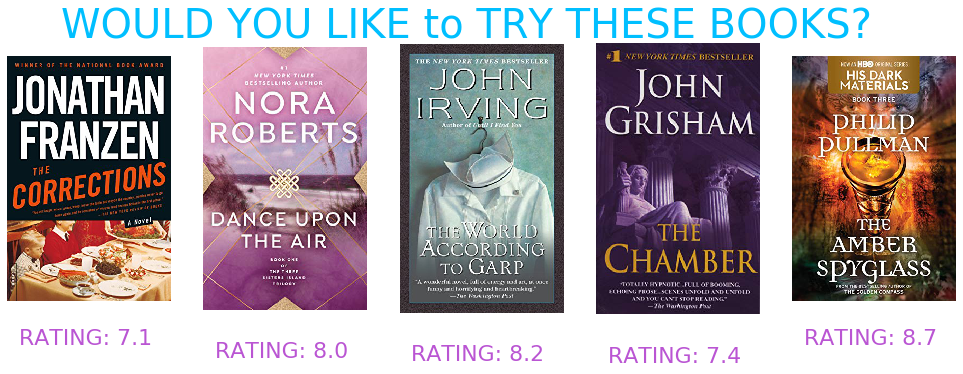

In [43]:
item_based("The Two Towers (The Lord of the Rings, Part 2)")

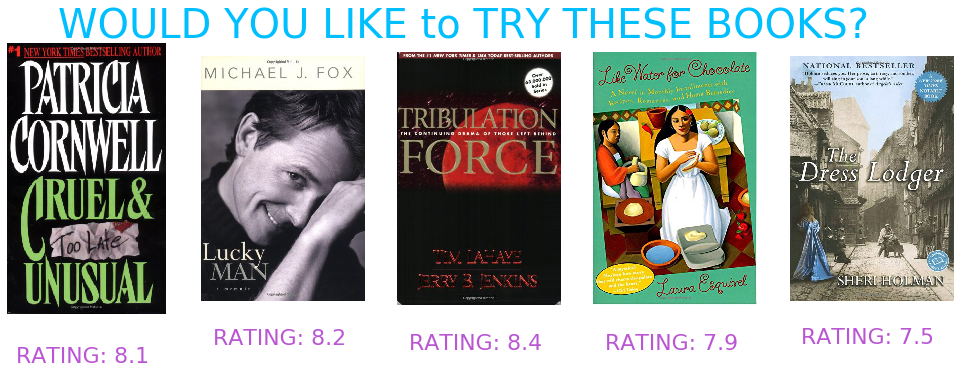

In [44]:
item_based("Me Talk Pretty One Day")

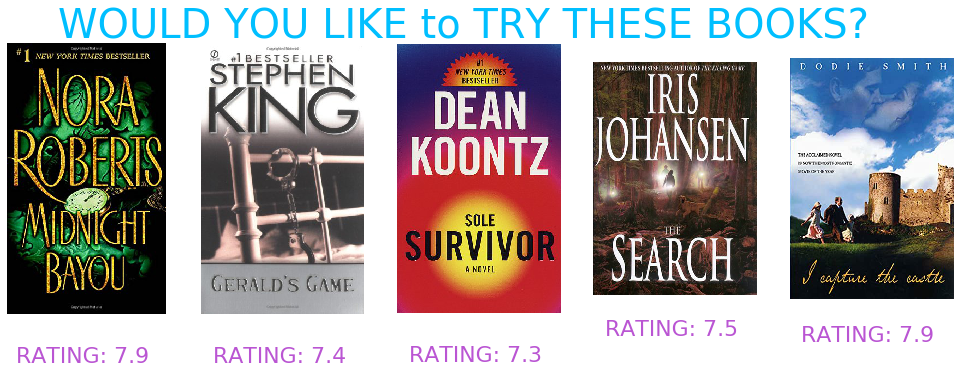

In [45]:
item_based("Harry Potter and the Goblet of Fire (Book 4)")

## User Based 

In [46]:
new_df=df5[df5['User-ID'].map(df5['User-ID'].value_counts()) > 90]  # Drop users who vote less than 90 times.
users_pivot=new_df.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
users_pivot.fillna(0,inplace=True)

In [47]:
#users_pivot.head()

In [120]:
def users_choice(id):
    
    users_fav=new_df[new_df["User-ID"]==id].sort_values(["Book-Rating"],ascending=False)[0:5]
    return users_fav

In [121]:
def user_based(new_df,id):
    if id not in new_df["User-ID"].values:
        print("❌ User NOT FOUND ❌")
        
        
    else:
        index=np.where(users_pivot.index==id)[0][0]
        similarity=cosine_similarity(users_pivot)
        similar_users=list(enumerate(similarity[index]))
        similar_users = sorted(similar_users,key = lambda x:x[1],reverse=True)[0:5]
    
        user_rec=[]
    
        for i in similar_users:
                data=df4[df4["User-ID"]==users_pivot.index[i[0]]]
                user_rec.extend(list(data.drop_duplicates("User-ID")["User-ID"].values))
        
    return user_rec

In [122]:
def common(new_df,user,user_id):
    x=new_df[new_df["User-ID"]==user_id]
    recommend_books=[]
    user=list(user)
    for i in user:
        y=new_df[(new_df["User-ID"]==i)]
        books=y.loc[~y["Book-Title"].isin(x["Book-Title"]),:]
        books=books.sort_values(["Book-Rating"],ascending=False)[0:5]
        recommend_books.extend(books["Book-Title"].values)
        
    return recommend_books[0:5]

🟦 USER: 224138.0 


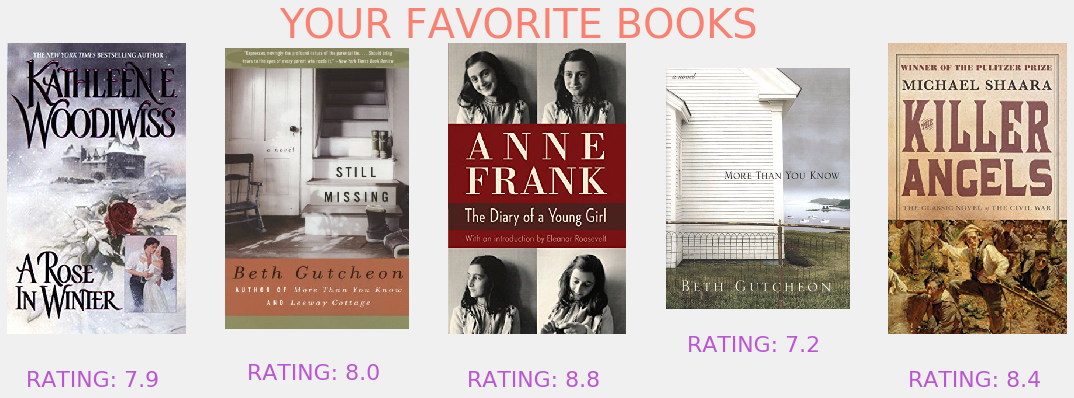

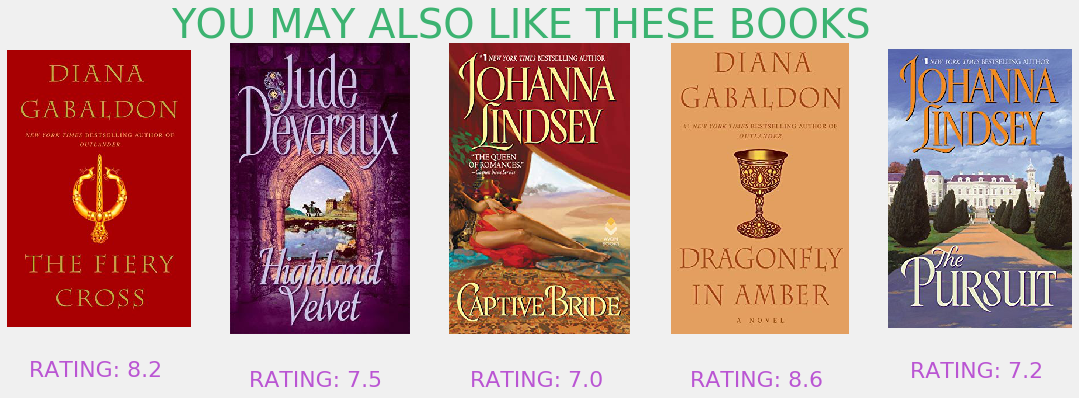

In [136]:
user_id = random.choice(new_df["User-ID"].values)
user_choice_df=pd.DataFrame(users_choice(user_id))
user_favorite=users_choice(user_id)
n=len(user_choice_df["Book-Title"].values)
print("🟦 USER: {} ".format(user_id))
    
fig,ax=plt.subplots(1,n,figsize=(17,5))
fig.suptitle("YOUR FAVORITE BOOKS",fontsize=40,color="salmon")
    
for i in range(n):
    
        url=new_df.loc[new_df["Book-Title"]==user_choice_df["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
        
        headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36' }
        response = requests.get(url, stream=True, headers = headers)
        img = Image.open(io.BytesIO(response.content))
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title("RATING: {} ".format(round(new_df[new_df["Book-Title"]==user_choice_df["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
        fig.show()

user_based_rec=user_based(new_df,user_id)
books_for_user=common(new_df,user_based_rec,user_id)
books_for_userDF=pd.DataFrame(books_for_user,columns=["Book-Title"])

fig,ax=plt.subplots(1,5,figsize=(17,5))
fig.suptitle("YOU MAY ALSO LIKE THESE BOOKS",fontsize=40,color="mediumseagreen")
for i in range(5):
    url=new_df.loc[new_df["Book-Title"]==books_for_userDF["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
    headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36' }
    response = requests.get(url, stream=True, headers = headers)
    img = Image.open(io.BytesIO(response.content))
                
    
    #img=Image.open(requests.get(url,stream=True).raw)
    ax[i].imshow(img)
    ax[i].axis("off")
    ax[i].set_title("RATING: {} ".format(round(new_df[new_df["Book-Title"]==books_for_userDF["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
    fig.show()
    

